In [46]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
from tqdm import tqdm

Data

In [60]:
np.random.seed(0)  # For reproducibility

def get_samples_() :
    n_samples = 20000
    x = np.random.normal(0, 1, n_samples)
    y = 3 * x + 4  # X1 and X2 are linearly related
    return x, y

def get_samples() :
    data = np.random.multivariate_normal( mean=[0,0],
                                          cov=[[1,0.8],[0.8,1]],
                                          size = 2000 )
    return data[:,0], data[:,1]


Network

In [61]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(1, 64)  # The input layer now takes a single feature
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x1, x2):
        x1 = F.relu(self.fc1(x1))
        x2 = F.relu(self.fc1(x2))  # Apply the first layer to both inputs
        x = (x1 + x2) / 2  # This gives you a tensor of shape (20000, 64)
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

mine_net = SimpleNet()
mine_optimizer = torch.optim.Adam(mine_net.parameters(), lr=0.01)

MiNe

In [62]:
def mutual_information(joint1, joint2, marginal, ma_rate=0.01):

    t = mine_net(joint1, joint2)
    et = torch.exp(mine_net(joint1, marginal))
    # the neural information measure by the Donskar-Varadhan representation
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))

    ma_et = (1-ma_rate)*et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
        
    return mi_lb, loss, ma_et

Loop

100%|██████████| 500/500 [00:11<00:00, 44.06it/s]


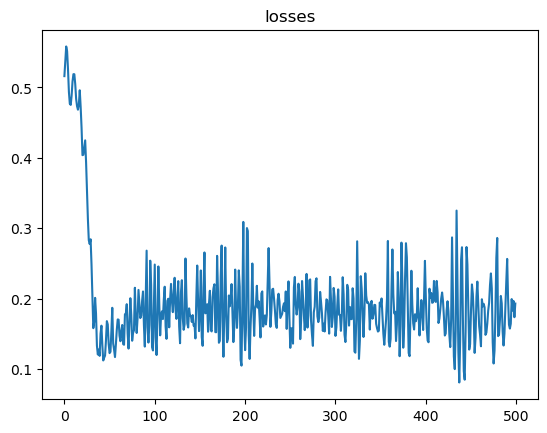

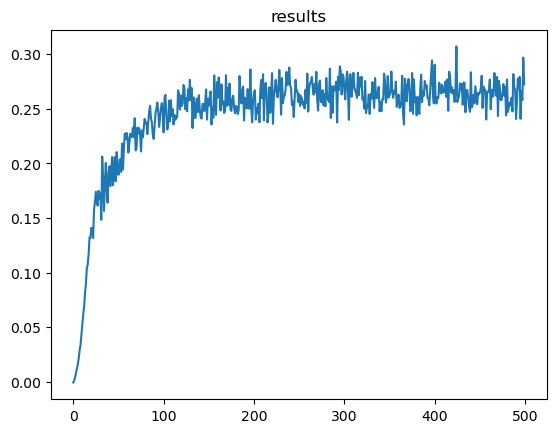

In [63]:
losses = []
results = []
n_epoch = 500

for epoch in tqdm((range(n_epoch))):
    x_sample, y_sample=get_samples()
    y_shuffle=np.random.permutation(y_sample)
    
    x_sample = Variable(torch.from_numpy(x_sample).type(torch.FloatTensor), requires_grad = True).view(-1, 1)
    y_sample = Variable(torch.from_numpy(y_sample).type(torch.FloatTensor), requires_grad = True).view(-1, 1)
    y_shuffle = Variable(torch.from_numpy(y_shuffle).type(torch.FloatTensor), requires_grad = True).view(-1, 1)
    
    result, loss, ma_et = mutual_information(x_sample, y_sample, y_shuffle)
    
    mine_optimizer.zero_grad()
    autograd.backward(loss)
    mine_optimizer.step()
        
    losses.append(loss.data.numpy())
    results.append(result.data.numpy())

plt.plot(losses)
plt.title("losses")
plt.show()

plt.plot(results)
plt.title("results")
plt.show()

100%|██████████| 500/500 [00:10<00:00, 45.58it/s]


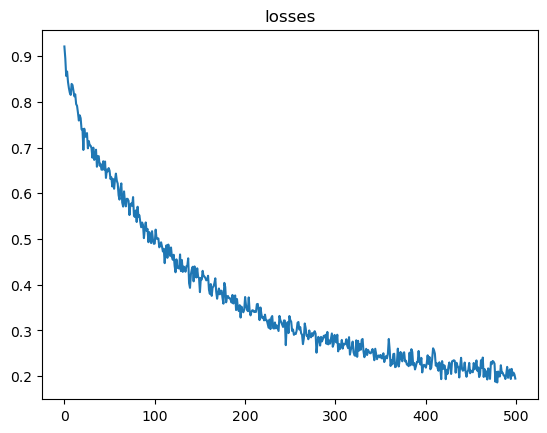

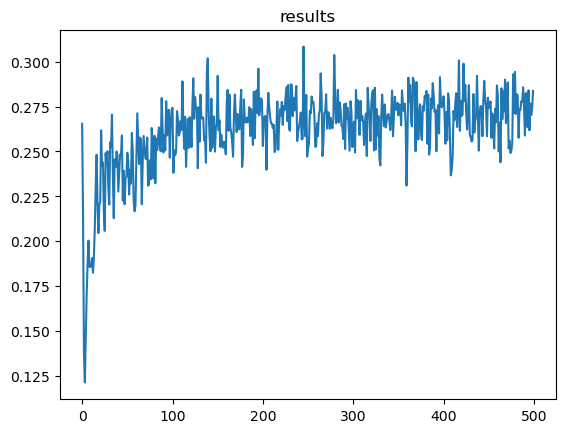

In [55]:


def mi(joint1, joint2, marginal, ma_et, ma_rate=0.01):

    t = mine_net(joint1, joint2)
    et = torch.exp(mine_net(joint1, marginal))
    # the neural information measure by the Donskar-Varadhan representation
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))

    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
        
    return mi_lb, loss, ma_et

losses = []
results = []
n_epoch = 500

ma_et = 1

for epoch in tqdm((range(n_epoch))):
    x_sample, y_sample=get_samples()
    y_shuffle=np.random.permutation(y_sample)
    
    x_sample = Variable(torch.from_numpy(x_sample).type(torch.FloatTensor), requires_grad = True).view(-1, 1)
    y_sample = Variable(torch.from_numpy(y_sample).type(torch.FloatTensor), requires_grad = True).view(-1, 1)
    y_shuffle = Variable(torch.from_numpy(y_shuffle).type(torch.FloatTensor), requires_grad = True).view(-1, 1)
    
    result, loss, ma_et = mi(x_sample, y_sample, y_shuffle, ma_et)
    
    mine_optimizer.zero_grad()
    autograd.backward(loss)
    mine_optimizer.step()
        
    losses.append(loss.data.numpy())
    results.append(result.data.numpy())

plt.plot(losses)
plt.title("losses")
plt.show()

plt.plot(results)
plt.title("results")
plt.show()